In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *
sys.path.append('/home/jvalenti/MOAD/SalishSeaTools')
from salishsea_tools import evaltools as et

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [3]:
df2=pd.read_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/timeg_2015t.csv', index_col=[0])

meantime2 = df2.groupby(by='DeployT').mean()
SD2 = df2.groupby(by='DeployT').sem()
meantime2.Timeg = meantime2.Timeg/24
SD2.Timeg = (SD2.Timeg/24)

In [4]:
df=pd.read_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/timeg_2016.csv', index_col=[0])

meantime = df.groupby(by='DeployT').mean()
SD = df.groupby(by='DeployT').sem()
meantime.Timeg = meantime.Timeg/24
SD.Timeg = (SD.Timeg/24)

In [5]:
def getWindVars(day):
    opsdir='/results/forcing/atmospheric/GEM2.5/operational/'
    nam_fmt='ops'
    jlims=(119,213)
    ilims=(96,163)
    return opsdir, nam_fmt, jlims,ilims

In [58]:
start = datetime(2015,1,1)

def Qubicwind_tmean(start, DeltaT):
    opsdir, namfmt, jlims, ilims = getWindVars(start)
    flist=et.index_model_files(start,start+DeltaT,opsdir,namfmt,
                            flen=1,ftype='None',tres=24);
    fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
    fu=xr.concat([ii['u_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
    fv=xr.concat([ii['v_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
    fud=xr.concat([ii['u_wind'].isel(x=72,y=62) for ii in fs],"time_counter")
    fvd=xr.concat([ii['v_wind'].isel(x=72,y=62) for ii in fs],"time_counter")
    Week1=(fu**2+fv**2)**(3/2)
    wind=(fu**2+fv**2)**(1/2)
    umean = np.nanmean(np.mean(fu,0))
    vmean = np.nanmean(np.mean(fv,0))
    Windir = np.arctan2(vmean,umean)
    Week1mean=np.mean(Week1,0)
    return np.nanmean(Windir), np.nanmean(Week1mean),np.nanmax(wind)
Qwind = [] 
Windir = [] 
Mwind = []
for i in range(1,104):
    Wdr,Qww,Wmm = Qubicwind_tmean(start, timedelta(days= 7))
    Mwind.append(Wmm)
    Qwind.append(Qww)
    Windir.append(Wdr)
    start = start+timedelta(days= 7)

KeyboardInterrupt: 

In [ ]:
start = datetime(2014,12,25)
Fraser_week = [] 
for i in range(104):
    Fraser_week.append(0)
    for j in range(168):
        Fraser_week[-1] += float(xr.open_dataset(get_Fraser_path(start+ timedelta(days= i*7,hours=j))).rorunoff[0,500,394].values)*211.8116*3600 #m3/h

In [ ]:
Dept2 = []
for i in range(104):
    Dept2.append(start+ timedelta(days= i*7))
Dept2 = np.array(Dept2, dtype='datetime64')

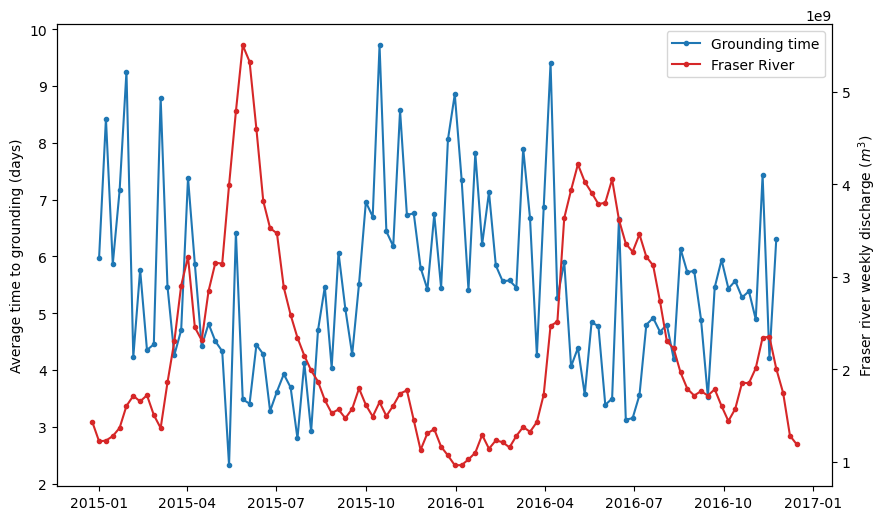

In [ ]:
Dept = meantime.index
Groundt = meantime.values
SE = SD.values
Groundt2 = meantime2.values


se = []
gt = []
gt2 = []
for i in range(52):
    gt2.append(Groundt2[i][0])
for i in range(48):
    se.append(SE[i][0])
    gt.append(Groundt[i][0])
    
GT =gt2+gt
fig,ax = plt.subplots(1,1,figsize=(10,6))

Twin1 = ax.twinx()
#p3 = ax.plot(Dept2[1:53],gt2,'.-',c='tab:blue',label = 'Grounding time')
#p1 = ax.plot(Dept2[53:-3],gt,'.-',c='tab:blue',label = 'Grounding time')
p1 = ax.plot(Dept2[1:-3],GT,'.-',c='tab:blue',label = 'Grounding time')
plt.xlabel('Time of particle deployment')
ax.set_ylabel('Average time to grounding (days)')
Twin1.set_ylabel('Fraser river weekly discharge ($m^3$)')
p2 = Twin1.plot(Dept2,Fraser_week,'.-',c='tab:red',label = 'Fraser River')

AX1 = p1+p2
labs = [l.get_label() for l in AX1]
ax.legend(AX1,labs)

In [6]:
df3=pd.read_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/timeg_2015d.csv', index_col=[0])
df4=pd.read_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/timeg_2016d.csv', index_col=[0])
frames = [df3,df4]
result = pd.concat(frames)

In [7]:
Timeg= np.array(result['Timeg'],dtype='datetime64[D]')
result['Timeg'] = Timeg

In [8]:
dfc = result.groupby(['Timeg'])['Timeg'].count()
Timeg = np.array(dfc.index,dtype='datetime64')
CountT = np.array(dfc.values)

In [12]:
# start = datetime(2015,1,1)

# def Qubicwind_tmean(start, DeltaT):
#     opsdir, namfmt, jlims, ilims = getWindVars(start)
#     flist=et.index_model_files(start,start+DeltaT,opsdir,namfmt,
#                             flen=1,ftype='None',tres=24);
#     fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
#     fu=xr.concat([ii['u_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#     fv=xr.concat([ii['v_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
#     fud=xr.concat([ii['u_wind'].isel(x=72,y=62) for ii in fs],"time_counter")
#     fvd=xr.concat([ii['v_wind'].isel(x=72,y=62) for ii in fs],"time_counter")
#     Week1=(fu**2+fv**2)**(3/2)
#     wind=(fu**2+fv**2)**(1/2)
#     umean = np.nanmean(np.mean(fu,0))
#     vmean = np.nanmean(np.mean(fv,0))
#     Windir = np.arctan2(vmean,umean)
#     Week1mean=np.mean(Week1,0)
#     return np.nanmean(Windir), np.nanmean(Week1mean),np.nanmax(wind)
# Qwind = [] 
# Windir = [] 
# Mwind = []
# Fraser_day = [] 
# for i in range(1,728):
#     Wdr,Qww,Wmm = Qubicwind_tmean(start, timedelta(days= 1))
#     Mwind.append(Wmm)
#     Qwind.append(Qww)
#     Windir.append(Wdr)
#     Fraser_day.append(0)
#     for j in range(24):
#         Fraser_day[-1] += float(xr.open_dataset(get_Fraser_path(datetime(2015,1,1)+ timedelta(days= i,hours=j))).rorunoff[0,500,394].values)*211.8116*3600 #m3/h
#     start = start+timedelta(days= 1)

In [14]:
start = datetime(2015,1,1)
TIME = []
for i in range(1,728):
    TIME.append(start+ timedelta(days= i))
TIME = np.array(TIME, dtype='datetime64')

In [13]:
df = pd.DataFrame({'time':TIME[1:],'Qwind':Qwind[1:],'Windir':Windir[1:],'Fraser':Fraser_day[1:],'Maxwind':Mwind[1:],'Count':CountT})
df.to_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/wind-river2015-2016.csv')

In [15]:
from scipy import signal

detrended = signal.detrend(CountT)
dw = signal.detrend(Qwind[1:])

In [18]:
np.corrcoef(detrended,Fraser_day[1:])

array([[1.        , 0.03572499],
       [0.03572499, 1.        ]])

array([[1.        , 0.01478918],
       [0.01478918, 1.        ]])

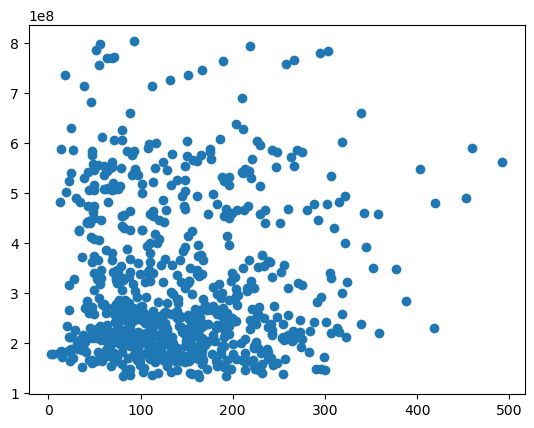

In [22]:
plt.scatter(CountT,Fraser_day[1:])
np.corrcoef(detrended,np.abs(np.cos(np.array(Windir[1:])+np.pi/4)))

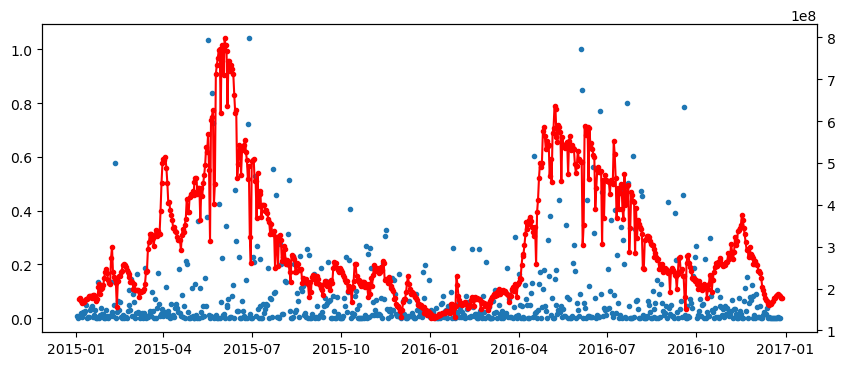

In [97]:
CM2=df['Windir'].rolling(2).mean()
CM2 =CM2/np.max(CM2)
fig,ax = plt.subplots(1,1,figsize=(10,4))
Twin1 = ax.twinx()
#ax.plot(Timeg[:365],CountT[:365],'.-')
ax.plot(Timeg,np.array(CM)**2,'.')
Twin1.plot(TIME[1:],np.multiply(Fraser_day[1:],np.cos(CM)),'r.-')
#ax[0].set_ylim([0,50])

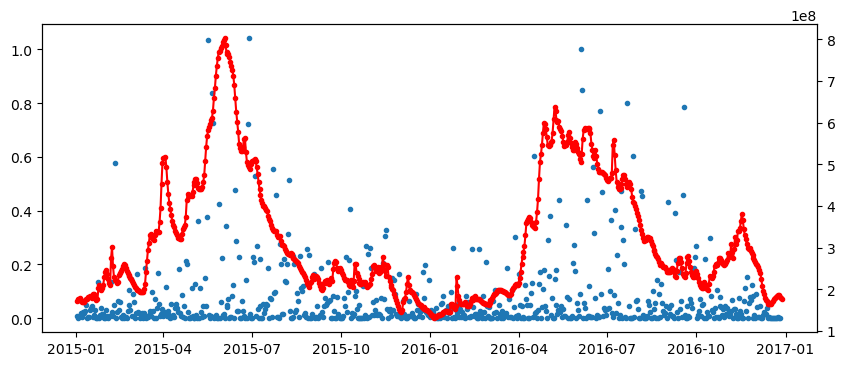

In [82]:
CM=df['Count']-df['Count'].rolling(2).mean()
CM =CM/np.max(CM)
fig,ax = plt.subplots(1,1,figsize=(10,4))
Twin1 = ax.twinx()
#ax.plot(Timeg[:365],CountT[:365],'.-')
ax.plot(Timeg,CM**2,'.')
Twin1.plot(TIME,Fraser_day,'r.-')
#ax[0].set_ylim([0,50])

(16640, 16740)

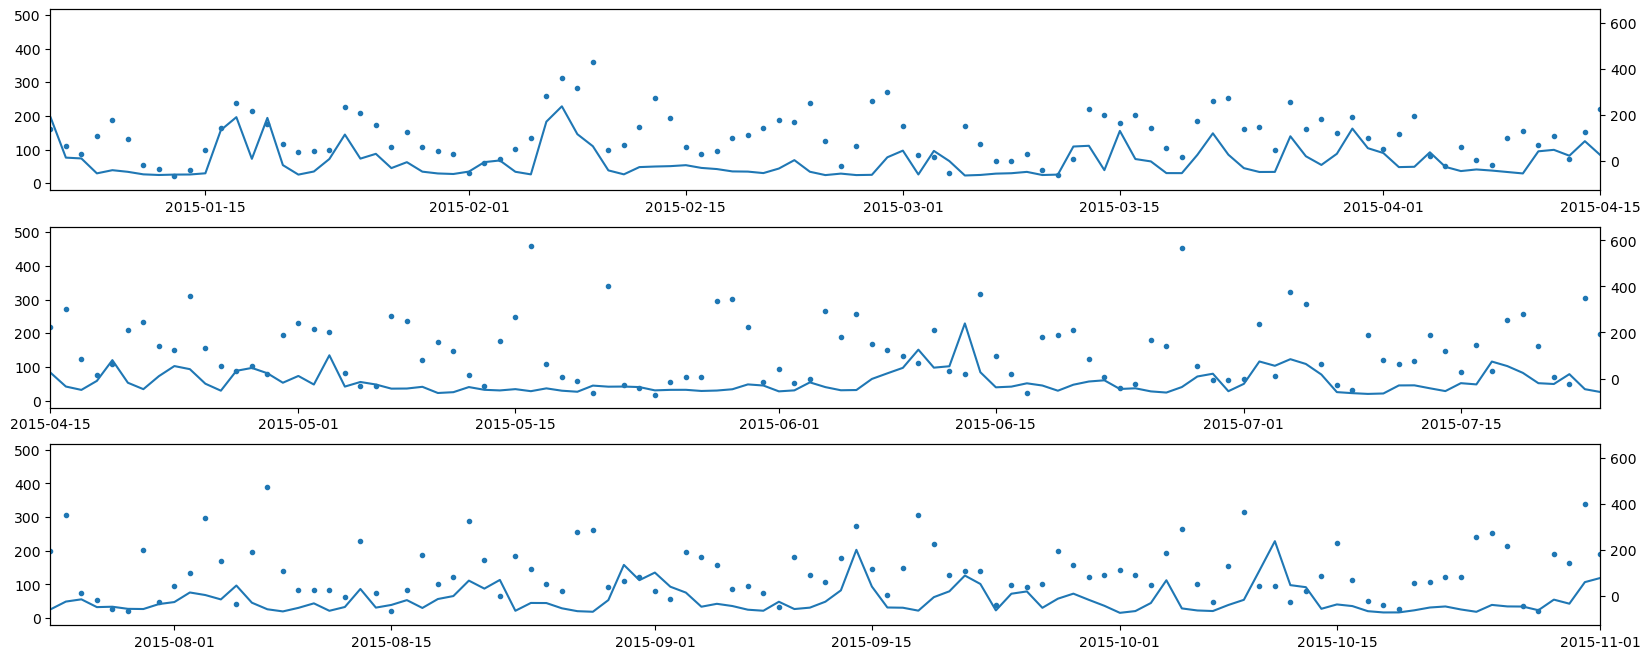

In [181]:
fig,ax = plt.subplots(3,1,figsize=(20,8))
Twin1 = ax[0].twinx()
Twin2 = ax[1].twinx()
Twin3 = ax[2].twinx()
ax[0].plot(Timeg,CountT,'.')
ax[0].set_xlim([16440,16540])
Twin1.plot(TIME[1:],dw)
#ax[0].set_ylim([0,50])

ax[1].plot(Timeg,CountT,'.')
Twin2.plot(TIME[1:],dw)
ax[1].set_xlim([16540,16640])
#ax[1].set_ylim([0,50])

ax[2].plot(Timeg,CountT,'.')
Twin3.plot(TIME[1:],dw)
ax[2].set_xlim([16640,16740])
#ax[2].set_ylim([0,50])

In [120]:
df = pd.DataFrame({'time':Dept2[1:-3],'Qwind':Qwind[:-3],'Windir':Windir[:-3],'TimeG':GT,'Fraser':Fraser_week[1:-3],'Maxwind':Mwind[:-3]})

In [147]:
a=df['TimeG'].rolling(3).mean().values

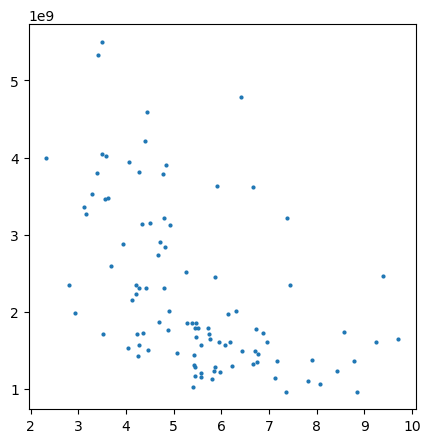

In [151]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.scatter(GT,Fraser_week[1:-3],s=4)

In [121]:
df.corr()

,Qwind,Windir,TimeG,Fraser,Maxwind
Qwind,1.000000,0.427843,0.098118,-0.296911,0.804131
Windir,0.427843,1.000000,0.140802,-0.258406,0.432901
TimeG,0.098118,0.140802,1.000000,-0.510777,0.245155
Fraser,-0.296911,-0.258406,-0.510777,1.000000,-0.439820
Maxwind,0.804131,0.432901,0.245155,-0.439820,1.000000


In [122]:
df.cov()

,Qwind,Windir,TimeG,Fraser,Maxwind
Qwind,3.404954e+03,3.592708e+01,9.057155e+00,-1.838678e+10,1.405880e+02
Windir,3.592708e+01,2.070925e+00,3.205378e-01,-3.946469e+08,1.866537e+00
TimeG,9.057155e+00,3.205378e-01,2.502522e+00,-8.575189e+08,1.161972e+00
Fraser,-1.838678e+10,-3.946469e+08,-8.575189e+08,1.126281e+18,-1.398505e+09
Maxwind,1.405880e+02,1.866537e+00,1.161972e+00,-1.398505e+09,8.977005e+00


In [149]:
df['Gdetrend'] = df['TimeG']-df['TimeG'].rolling(3).mean()
df['Gseas'] = df['TimeG'].rolling(3).mean()
df['Windirdet'] = df['Windir']-df['Windir'].rolling(3).mean()

In [150]:
df.corr()

,Qwind,Windir,TimeG,Fraser,Maxwind,Gdetrend,Windirdet,Gseas
Qwind,1.000000,0.427843,0.098118,-0.296911,0.804131,-0.121943,0.147566,0.270144
Windir,0.427843,1.000000,0.140802,-0.258406,0.432901,-0.072028,0.723769,0.300846
TimeG,0.098118,0.140802,1.000000,-0.510777,0.245155,0.644035,0.028174,0.745295
Fraser,-0.296911,-0.258406,-0.510777,1.000000,-0.439820,-0.038121,-0.081193,-0.624131
Maxwind,0.804131,0.432901,0.245155,-0.439820,1.000000,-0.132324,0.171027,0.457075
Gdetrend,-0.121943,-0.072028,0.644035,-0.038121,-0.132324,1.000000,-0.022484,-0.030054
Windirdet,0.147566,0.723769,0.028174,-0.081193,0.171027,-0.022484,1.000000,0.056409
Gseas,0.270144,0.300846,0.745295,-0.624131,0.457075,-0.030054,0.056409,1.000000
